# A2C

A2C (advantage actor critic) is simpler version of [A3C (asynchronous advantage actor critic)](https://arxiv.org/abs/1602.01783) algorithm. It is similar to policy gradient algorithm with following adaptations:
* Number of environments are run in parallel to reduce correlations between samples,
* Neural network predicts both policy outputs (action probabilities) and value function. Value function is used for bootstrapping return when trajectory length is fixed (in policy gradients the trajectory always had to go till the end of episode). Additionally the value function is used as a baseline when calculating advantage.

Following is a rough implementation of the algorithm, which at least seems to work for Atari Pong.

In [1]:
import gym
import numpy as np

from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, Flatten, LSTM, Dense
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop

from atari_utils import RandomizedResetEnv, AtariRescale42x42Env, AtariRescale84x84Env, ObservationBuffer

Using TensorFlow backend.


In [2]:
# helper function to create environment with required wrappers
def create_env(env_id):
    env = gym.make(env_id)
    env = RandomizedResetEnv(env)
    #env = AtariRescale42x42Env(env)
    # resize screen to 84x84
    env = AtariRescale84x84Env(env)
    env = ObservationBuffer(env)
    return env

In [3]:
# create temporary environment to fetch observation and action space
env = create_env('PongDeterministic-v4')

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

OBS_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n

env.close()

Observation space: Box(84, 84, 4)
Action space: Discrete(6)


In [4]:
# create model with standard DeepMind architecture
x = Input(shape=OBS_SHAPE, name='x')
h = Conv2D(16, 8, strides=4, padding='valid', activation='relu', name='c1')(x)
h = Conv2D(32, 4, strides=2, padding='valid', activation='relu', name='c2')(h)
h = Flatten(name='fl')(h)

# policy head
h1 = Dense(256, activation='relu', name='h1')(h)
p = Dense(NUM_ACTIONS, activation='softmax', kernel_initializer=RandomNormal(stddev=0.01), name='p')(h1)

# value head
h2 = Dense(256, activation='relu', name='h2')(h)
v = Dense(1, name="v")(h2)

# model for training
model = Model(x, [p, v])
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=RMSprop(lr=0.0003))
model.summary()

# prediction-only models for policy and value
policynet = Model(x, p)
valuenet = Model(x, v)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
c1 (Conv2D)                     (None, 20, 20, 16)   4112        x[0][0]                          
__________________________________________________________________________________________________
c2 (Conv2D)                     (None, 9, 9, 32)     8224        c1[0][0]                         
__________________________________________________________________________________________________
fl (Flatten)                    (None, 2592)         0           c2[0][0]                         
_____________________________________

In [5]:
GAMMA = 0.9

# discounting using value function for bootstrapping
def discount(rewards, dones, value):
    ret = value
    returns = np.empty_like(rewards)
    for t in reversed(range(rewards.shape[1])):
        ret = rewards[:, t] + GAMMA * (1 - dones[:, t]) * ret
        returns[:, t] = ret
    return returns

In [6]:
NUM_ACTORS = 20
NUM_TIMESTEPS = 5

# create buffers for training data
states = np.empty((NUM_ACTORS, NUM_TIMESTEPS + 1) + OBS_SHAPE)
actions = np.empty((NUM_ACTORS, NUM_TIMESTEPS), dtype=np.uint8)
rewards = np.empty((NUM_ACTORS, NUM_TIMESTEPS))
dones = np.empty((NUM_ACTORS, NUM_TIMESTEPS), dtype=np.uint8)

# create environments for all actors
envs = []
for i in range(NUM_ACTORS):
    env = create_env('PongDeterministic-v4')
    envs.append(env)

    state = env.reset()
    states[i, 0] = state

/home/tambet/.conda/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'atari_utils.ObservationBuffer'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor()

def actor_step(i):
    # sample action
    action = np.random.choice(NUM_ACTIONS, p=probs[i])
    # step environment
    state, reward, done, info = envs[i].step(action)

    # record episode reward and length
    actor_rewards[i] += reward
    actor_lengths[i] += 1

    # if episode finished
    if done:
        # start new episode
        state = envs[i].reset()

        # log episode data
        episode_reward = actor_rewards[i]
        episode_length = actor_lengths[i]
        actor_rewards[i] = 0
        actor_lengths[i] = 0
    else:
        episode_reward = None
        episode_length = None
        
    # record training data
    states[i, t + 1] = state
    actions[i, t] = action
    rewards[i, t] = reward
    dones[i, t] = done

    return episode_reward, episode_length

TOTAL_TIMESTEPS = 5000000

episode_rewards = []
episode_lengths = []
actor_rewards = np.zeros(NUM_ACTORS)
actor_lengths = np.zeros(NUM_ACTORS)
# train for 5M timesteps
for n in range(TOTAL_TIMESTEPS // (NUM_ACTORS * NUM_TIMESTEPS)):
    # train every NUM_TIMESTEPS
    for t in range(NUM_TIMESTEPS):
        # predict action probabilities using policy network
        probs = policynet.predict_on_batch(states[:,t])        
        
        # step all actors
        results = executor.map(actor_step, range(NUM_ACTORS))
        for i, (episode_reward, episode_length) in enumerate(results):
            if episode_reward is not None:
                episode_rewards.append(episode_reward)
                episode_lengths.append(episode_length)

                print("Episode:", len(episode_rewards), "Reward:", episode_reward, "Length:", episode_length, "Actor:", i, "Timestep:", n * NUM_ACTORS * NUM_TIMESTEPS + t * NUM_ACTORS + i + 1)
            
    # predict baseline values for all states, including the last
    values = valuenet.predict_on_batch(states.reshape((-1,) + states.shape[2:]))
    values = values.reshape((NUM_ACTORS, NUM_TIMESTEPS + 1))

    # perform discounting using the last value for bootstrapping
    returns = discount(rewards, dones, values[:, -1])
    # compute advantages
    advantages = returns - values[:, :-1]

    # train model
    losses = model.train_on_batch(states[:, :-1].reshape((-1,) + states.shape[2:]), 
        [actions.reshape((-1, 1)), returns.reshape((-1, 1))], 
        sample_weight=[advantages.flatten(), None])
    #print("Timestep:", n, "losses:", losses)
    
    # copy last state to be the first
    states[:, 0] = states[:, -1]

Instructions for updating:
Use tf.cast instead.
Episode: 1 Reward: -21.0 Length: 754.0 Actor: 10 Timestep: 15071
Episode: 2 Reward: -21.0 Length: 772.0 Actor: 3 Timestep: 15424
Episode: 3 Reward: -21.0 Length: 815.0 Actor: 9 Timestep: 16290
Episode: 4 Reward: -21.0 Length: 816.0 Actor: 1 Timestep: 16302
Episode: 5 Reward: -21.0 Length: 822.0 Actor: 11 Timestep: 16432
Episode: 6 Reward: -20.0 Length: 830.0 Actor: 2 Timestep: 16583
Episode: 7 Reward: -21.0 Length: 844.0 Actor: 5 Timestep: 16866
Episode: 8 Reward: -21.0 Length: 858.0 Actor: 0 Timestep: 17141
Episode: 9 Reward: -21.0 Length: 871.0 Actor: 15 Timestep: 17416
Episode: 10 Reward: -20.0 Length: 890.0 Actor: 6 Timestep: 17787
Episode: 11 Reward: -21.0 Length: 890.0 Actor: 19 Timestep: 17800
Episode: 12 Reward: -20.0 Length: 899.0 Actor: 12 Timestep: 17973
Episode: 13 Reward: -21.0 Length: 904.0 Actor: 7 Timestep: 18068
Episode: 14 Reward: -20.0 Length: 913.0 Actor: 4 Timestep: 18245
Episode: 15 Reward: -19.0 Length: 929.0 Actor:

Episode: 122 Reward: -20.0 Length: 837.0 Actor: 0 Timestep: 116721
Episode: 123 Reward: -21.0 Length: 790.0 Actor: 10 Timestep: 117611
Episode: 124 Reward: -21.0 Length: 852.0 Actor: 9 Timestep: 117670
Episode: 125 Reward: -21.0 Length: 908.0 Actor: 1 Timestep: 119142
Episode: 126 Reward: -21.0 Length: 777.0 Actor: 8 Timestep: 120069
Episode: 127 Reward: -20.0 Length: 868.0 Actor: 5 Timestep: 120446
Episode: 128 Reward: -20.0 Length: 836.0 Actor: 16 Timestep: 121057
Episode: 129 Reward: -19.0 Length: 931.0 Actor: 14 Timestep: 121295
Episode: 130 Reward: -20.0 Length: 914.0 Actor: 17 Timestep: 121878
Episode: 131 Reward: -21.0 Length: 848.0 Actor: 2 Timestep: 121963
Episode: 132 Reward: -21.0 Length: 887.0 Actor: 13 Timestep: 122094
Episode: 133 Reward: -20.0 Length: 832.0 Actor: 18 Timestep: 122699
Episode: 134 Reward: -21.0 Length: 850.0 Actor: 12 Timestep: 122813
Episode: 135 Reward: -20.0 Length: 927.0 Actor: 7 Timestep: 123608
Episode: 136 Reward: -20.0 Length: 838.0 Actor: 19 Time

Episode: 244 Reward: -19.0 Length: 1077.0 Actor: 10 Timestep: 222471
Episode: 245 Reward: -21.0 Length: 783.0 Actor: 4 Timestep: 223425
Episode: 246 Reward: -21.0 Length: 854.0 Actor: 18 Timestep: 223659
Episode: 247 Reward: -21.0 Length: 902.0 Actor: 1 Timestep: 227862
Episode: 248 Reward: -20.0 Length: 1026.0 Actor: 9 Timestep: 229610
Episode: 249 Reward: -20.0 Length: 837.0 Actor: 3 Timestep: 229904
Episode: 250 Reward: -20.0 Length: 882.0 Actor: 2 Timestep: 230383
Episode: 251 Reward: -20.0 Length: 1004.0 Actor: 16 Timestep: 231017
Episode: 252 Reward: -21.0 Length: 934.0 Actor: 19 Timestep: 231120
Episode: 253 Reward: -20.0 Length: 867.0 Actor: 6 Timestep: 231527
Episode: 254 Reward: -19.0 Length: 1018.0 Actor: 13 Timestep: 232254
Episode: 255 Reward: -21.0 Length: 824.0 Actor: 0 Timestep: 233401
Episode: 256 Reward: -20.0 Length: 1056.0 Actor: 17 Timestep: 234218
Episode: 257 Reward: -20.0 Length: 884.0 Actor: 8 Timestep: 235449
Episode: 258 Reward: -19.0 Length: 1067.0 Actor: 15

Episode: 365 Reward: -20.0 Length: 867.0 Actor: 18 Timestep: 338539
Episode: 366 Reward: -20.0 Length: 955.0 Actor: 19 Timestep: 340840
Episode: 367 Reward: -21.0 Length: 780.0 Actor: 8 Timestep: 341529
Episode: 368 Reward: -21.0 Length: 925.0 Actor: 4 Timestep: 341885
Episode: 369 Reward: -20.0 Length: 836.0 Actor: 6 Timestep: 342547
Episode: 370 Reward: -20.0 Length: 886.0 Actor: 3 Timestep: 343804
Episode: 371 Reward: -21.0 Length: 788.0 Actor: 17 Timestep: 343838
Episode: 372 Reward: -21.0 Length: 837.0 Actor: 1 Timestep: 344982
Episode: 373 Reward: -21.0 Length: 959.0 Actor: 0 Timestep: 347141
Episode: 374 Reward: -19.0 Length: 1077.0 Actor: 10 Timestep: 348211
Episode: 375 Reward: -20.0 Length: 925.0 Actor: 15 Timestep: 348256
Episode: 376 Reward: -21.0 Length: 914.0 Actor: 9 Timestep: 348750
Episode: 377 Reward: -18.0 Length: 1073.0 Actor: 2 Timestep: 349603
Episode: 378 Reward: -19.0 Length: 961.0 Actor: 14 Timestep: 351595
Episode: 379 Reward: -20.0 Length: 950.0 Actor: 13 Tim

Episode: 486 Reward: -21.0 Length: 839.0 Actor: 15 Timestep: 457616
Episode: 487 Reward: -17.0 Length: 1200.0 Actor: 18 Timestep: 457719
Episode: 488 Reward: -21.0 Length: 974.0 Actor: 5 Timestep: 458146
Episode: 489 Reward: -19.0 Length: 1200.0 Actor: 0 Timestep: 458921
Episode: 490 Reward: -19.0 Length: 1010.0 Actor: 17 Timestep: 458978
Episode: 491 Reward: -20.0 Length: 938.0 Actor: 3 Timestep: 459244
Episode: 492 Reward: -21.0 Length: 829.0 Actor: 2 Timestep: 459303
Episode: 493 Reward: -19.0 Length: 982.0 Actor: 12 Timestep: 460853
Episode: 494 Reward: -19.0 Length: 1112.0 Actor: 1 Timestep: 462322
Episode: 495 Reward: -20.0 Length: 964.0 Actor: 9 Timestep: 462990
Episode: 496 Reward: -21.0 Length: 930.0 Actor: 7 Timestep: 464028
Episode: 497 Reward: -20.0 Length: 925.0 Actor: 4 Timestep: 464325
Episode: 498 Reward: -20.0 Length: 1003.0 Actor: 10 Timestep: 467731
Episode: 499 Reward: -21.0 Length: 925.0 Actor: 16 Timestep: 469857
Episode: 500 Reward: -19.0 Length: 997.0 Actor: 11 

Episode: 607 Reward: -20.0 Length: 1167.0 Actor: 13 Timestep: 587054
Episode: 608 Reward: -19.0 Length: 1309.0 Actor: 19 Timestep: 587500
Episode: 609 Reward: -19.0 Length: 1184.0 Actor: 9 Timestep: 588390
Episode: 610 Reward: -19.0 Length: 1133.0 Actor: 7 Timestep: 590088
Episode: 611 Reward: -18.0 Length: 1331.0 Actor: 8 Timestep: 591729
Episode: 612 Reward: -17.0 Length: 1213.0 Actor: 2 Timestep: 592363
Episode: 613 Reward: -18.0 Length: 1439.0 Actor: 17 Timestep: 593218
Episode: 614 Reward: -20.0 Length: 1078.0 Actor: 4 Timestep: 593785
Episode: 615 Reward: -20.0 Length: 1061.0 Actor: 18 Timestep: 598739
Episode: 616 Reward: -17.0 Length: 1272.0 Actor: 15 Timestep: 599936
Episode: 617 Reward: -20.0 Length: 1142.0 Actor: 5 Timestep: 602186
Episode: 618 Reward: -21.0 Length: 1121.0 Actor: 14 Timestep: 603535
Episode: 619 Reward: -19.0 Length: 1156.0 Actor: 6 Timestep: 604267
Episode: 620 Reward: -21.0 Length: 1111.0 Actor: 0 Timestep: 605101
Episode: 621 Reward: -18.0 Length: 1298.0 

Episode: 727 Reward: -18.0 Length: 1561.0 Actor: 1 Timestep: 756902
Episode: 728 Reward: -17.0 Length: 1515.0 Actor: 2 Timestep: 757323
Episode: 729 Reward: -17.0 Length: 1523.0 Actor: 7 Timestep: 759028
Episode: 730 Reward: -14.0 Length: 1689.0 Actor: 12 Timestep: 759233
Episode: 731 Reward: -17.0 Length: 1584.0 Actor: 9 Timestep: 760690
Episode: 732 Reward: -17.0 Length: 1495.0 Actor: 18 Timestep: 763339
Episode: 733 Reward: -20.0 Length: 1318.0 Actor: 6 Timestep: 763607
Episode: 734 Reward: -20.0 Length: 1249.0 Actor: 16 Timestep: 764657
Episode: 735 Reward: -15.0 Length: 1574.0 Actor: 8 Timestep: 765209
Episode: 736 Reward: -18.0 Length: 1526.0 Actor: 17 Timestep: 765938
Episode: 737 Reward: -18.0 Length: 1363.0 Actor: 15 Timestep: 770496
Episode: 738 Reward: -16.0 Length: 1402.0 Actor: 4 Timestep: 773825
Episode: 739 Reward: -15.0 Length: 1559.0 Actor: 5 Timestep: 777246
Episode: 740 Reward: -17.0 Length: 1373.0 Actor: 14 Timestep: 777715
Episode: 741 Reward: -17.0 Length: 1592.0 

Episode: 847 Reward: -9.0 Length: 1948.0 Actor: 13 Timestep: 958474
Episode: 848 Reward: -11.0 Length: 1844.0 Actor: 2 Timestep: 960823
Episode: 849 Reward: -10.0 Length: 1996.0 Actor: 12 Timestep: 966093
Episode: 850 Reward: -10.0 Length: 1879.0 Actor: 8 Timestep: 967689
Episode: 851 Reward: -11.0 Length: 1841.0 Actor: 11 Timestep: 968192
Episode: 852 Reward: -11.0 Length: 1872.0 Actor: 1 Timestep: 971182
Episode: 853 Reward: -9.0 Length: 1968.0 Actor: 6 Timestep: 973387
Episode: 854 Reward: -12.0 Length: 1869.0 Actor: 17 Timestep: 973538
Episode: 855 Reward: -11.0 Length: 1869.0 Actor: 15 Timestep: 977536
Episode: 856 Reward: -11.0 Length: 1777.0 Actor: 18 Timestep: 979059
Episode: 857 Reward: -11.0 Length: 1891.0 Actor: 16 Timestep: 981677
Episode: 858 Reward: -12.0 Length: 1754.0 Actor: 5 Timestep: 985726
Episode: 859 Reward: -12.0 Length: 1808.0 Actor: 7 Timestep: 986388
Episode: 860 Reward: -12.0 Length: 1748.0 Actor: 14 Timestep: 986395
Episode: 861 Reward: -10.0 Length: 1945.0 

Episode: 967 Reward: 5.0 Length: 2590.0 Actor: 0 Timestep: 1243021
Episode: 968 Reward: 3.0 Length: 2837.0 Actor: 8 Timestep: 1243649
Episode: 969 Reward: 5.0 Length: 2632.0 Actor: 4 Timestep: 1248825
Episode: 970 Reward: 3.0 Length: 2872.0 Actor: 2 Timestep: 1249483
Episode: 971 Reward: 4.0 Length: 2793.0 Actor: 5 Timestep: 1250186
Episode: 972 Reward: 1.0 Length: 2914.0 Actor: 15 Timestep: 1250836
Episode: 973 Reward: -5.0 Length: 2588.0 Actor: 18 Timestep: 1251139
Episode: 974 Reward: -2.0 Length: 2907.0 Actor: 11 Timestep: 1254192
Episode: 975 Reward: 10.0 Length: 2309.0 Actor: 16 Timestep: 1255457
Episode: 976 Reward: 2.0 Length: 2805.0 Actor: 6 Timestep: 1256347
Episode: 977 Reward: 8.0 Length: 2602.0 Actor: 17 Timestep: 1256778
Episode: 978 Reward: 1.0 Length: 3042.0 Actor: 12 Timestep: 1259713
Episode: 979 Reward: 5.0 Length: 2640.0 Actor: 13 Timestep: 1264814
Episode: 980 Reward: -3.0 Length: 2789.0 Actor: 9 Timestep: 1267950
Episode: 981 Reward: 5.0 Length: 2631.0 Actor: 3 Ti

Episode: 1087 Reward: 11.0 Length: 2390.0 Actor: 12 Timestep: 1550893
Episode: 1088 Reward: 13.0 Length: 2328.0 Actor: 4 Timestep: 1551385
Episode: 1089 Reward: 14.0 Length: 2354.0 Actor: 7 Timestep: 1551868
Episode: 1090 Reward: 15.0 Length: 2264.0 Actor: 16 Timestep: 1552397
Episode: 1091 Reward: 9.0 Length: 2508.0 Actor: 5 Timestep: 1552526
Episode: 1092 Reward: 10.0 Length: 2399.0 Actor: 6 Timestep: 1553487
Episode: 1093 Reward: 14.0 Length: 2207.0 Actor: 11 Timestep: 1557172
Episode: 1094 Reward: 13.0 Length: 2287.0 Actor: 18 Timestep: 1557599
Episode: 1095 Reward: 17.0 Length: 2202.0 Actor: 15 Timestep: 1560976
Episode: 1096 Reward: 5.0 Length: 2664.0 Actor: 0 Timestep: 1565341
Episode: 1097 Reward: 9.0 Length: 2577.0 Actor: 1 Timestep: 1569542
Episode: 1098 Reward: 10.0 Length: 2449.0 Actor: 19 Timestep: 1573840
Episode: 1099 Reward: 16.0 Length: 2304.0 Actor: 14 Timestep: 1574135
Episode: 1100 Reward: 16.0 Length: 2156.0 Actor: 13 Timestep: 1575894
Episode: 1101 Reward: 11.0 Le

Episode: 1206 Reward: 13.0 Length: 2256.0 Actor: 7 Timestep: 1815248
Episode: 1207 Reward: 17.0 Length: 2054.0 Actor: 4 Timestep: 1816285
Episode: 1208 Reward: 17.0 Length: 1927.0 Actor: 18 Timestep: 1818159
Episode: 1209 Reward: 20.0 Length: 1948.0 Actor: 6 Timestep: 1818647
Episode: 1210 Reward: 11.0 Length: 2490.0 Actor: 10 Timestep: 1820531
Episode: 1211 Reward: 13.0 Length: 2472.0 Actor: 12 Timestep: 1820553
Episode: 1212 Reward: 14.0 Length: 2269.0 Actor: 19 Timestep: 1828460
Episode: 1213 Reward: 20.0 Length: 1877.0 Actor: 0 Timestep: 1828721
Episode: 1214 Reward: 14.0 Length: 2285.0 Actor: 8 Timestep: 1831369
Episode: 1215 Reward: 12.0 Length: 2290.0 Actor: 11 Timestep: 1831512
Episode: 1216 Reward: 18.0 Length: 2081.0 Actor: 14 Timestep: 1834075
Episode: 1217 Reward: 16.0 Length: 2105.0 Actor: 13 Timestep: 1834914
Episode: 1218 Reward: 15.0 Length: 2203.0 Actor: 16 Timestep: 1835857
Episode: 1219 Reward: 20.0 Length: 1968.0 Actor: 15 Timestep: 1837096
Episode: 1220 Reward: 20.

Episode: 1324 Reward: 19.0 Length: 2050.0 Actor: 18 Timestep: 2069999
Episode: 1325 Reward: 17.0 Length: 2226.0 Actor: 17 Timestep: 2071998
Episode: 1326 Reward: 18.0 Length: 2105.0 Actor: 2 Timestep: 2073443
Episode: 1327 Reward: 19.0 Length: 1988.0 Actor: 12 Timestep: 2073613
Episode: 1328 Reward: 20.0 Length: 2055.0 Actor: 14 Timestep: 2073915
Episode: 1329 Reward: 15.0 Length: 2294.0 Actor: 10 Timestep: 2075851
Episode: 1330 Reward: 16.0 Length: 2136.0 Actor: 9 Timestep: 2076830
Episode: 1331 Reward: 18.0 Length: 2015.0 Actor: 6 Timestep: 2079447
Episode: 1332 Reward: 19.0 Length: 1802.0 Actor: 15 Timestep: 2090236
Episode: 1333 Reward: 18.0 Length: 1971.0 Actor: 13 Timestep: 2091974
Episode: 1334 Reward: 20.0 Length: 1922.0 Actor: 19 Timestep: 2093960
Episode: 1335 Reward: 20.0 Length: 1791.0 Actor: 1 Timestep: 2095542
Episode: 1336 Reward: 17.0 Length: 2081.0 Actor: 3 Timestep: 2095744
Episode: 1337 Reward: 20.0 Length: 1791.0 Actor: 16 Timestep: 2096397
Episode: 1338 Reward: 20.

Episode: 1442 Reward: 18.0 Length: 1772.0 Actor: 5 Timestep: 2279526
Episode: 1443 Reward: 20.0 Length: 1667.0 Actor: 18 Timestep: 2280599
Episode: 1444 Reward: 20.0 Length: 1709.0 Actor: 7 Timestep: 2281128
Episode: 1445 Reward: 20.0 Length: 1668.0 Actor: 4 Timestep: 2281265
Episode: 1446 Reward: 18.0 Length: 1774.0 Actor: 10 Timestep: 2281351
Episode: 1447 Reward: 20.0 Length: 1664.0 Actor: 12 Timestep: 2282293
Episode: 1448 Reward: 20.0 Length: 1663.0 Actor: 9 Timestep: 2282750
Episode: 1449 Reward: 20.0 Length: 1667.0 Actor: 17 Timestep: 2286538
Episode: 1450 Reward: 20.0 Length: 1662.0 Actor: 6 Timestep: 2288147
Episode: 1451 Reward: 17.0 Length: 1876.0 Actor: 14 Timestep: 2289315
Episode: 1452 Reward: 20.0 Length: 1663.0 Actor: 13 Timestep: 2293494
Episode: 1453 Reward: 20.0 Length: 1664.0 Actor: 11 Timestep: 2297172
Episode: 1454 Reward: 20.0 Length: 1662.0 Actor: 19 Timestep: 2299200
Episode: 1455 Reward: 20.0 Length: 1665.0 Actor: 15 Timestep: 2300556
Episode: 1456 Reward: 20.

Episode: 1560 Reward: 17.0 Length: 1810.0 Actor: 2 Timestep: 2478823
Episode: 1561 Reward: 20.0 Length: 1666.0 Actor: 18 Timestep: 2480319
Episode: 1562 Reward: 20.0 Length: 1668.0 Actor: 0 Timestep: 2482081
Episode: 1563 Reward: 20.0 Length: 1668.0 Actor: 7 Timestep: 2482928
Episode: 1564 Reward: 20.0 Length: 1663.0 Actor: 10 Timestep: 2484291
Episode: 1565 Reward: 20.0 Length: 1662.0 Actor: 4 Timestep: 2485965
Episode: 1566 Reward: 20.0 Length: 1666.0 Actor: 9 Timestep: 2487030
Episode: 1567 Reward: 19.0 Length: 1735.0 Actor: 5 Timestep: 2487306
Episode: 1568 Reward: 20.0 Length: 1661.0 Actor: 17 Timestep: 2488838
Episode: 1569 Reward: 20.0 Length: 1664.0 Actor: 12 Timestep: 2489893
Episode: 1570 Reward: 20.0 Length: 1663.0 Actor: 6 Timestep: 2490487
Episode: 1571 Reward: 20.0 Length: 1668.0 Actor: 13 Timestep: 2495574
Episode: 1572 Reward: 20.0 Length: 1663.0 Actor: 11 Timestep: 2496832
Episode: 1573 Reward: 18.0 Length: 1877.0 Actor: 14 Timestep: 2500275
Episode: 1574 Reward: 20.0 

Episode: 1678 Reward: 20.0 Length: 1667.0 Actor: 0 Timestep: 2684401
Episode: 1679 Reward: 20.0 Length: 1668.0 Actor: 10 Timestep: 2685791
Episode: 1680 Reward: 20.0 Length: 1666.0 Actor: 15 Timestep: 2686476
Episode: 1681 Reward: 20.0 Length: 1667.0 Actor: 18 Timestep: 2686979
Episode: 1682 Reward: 20.0 Length: 1662.0 Actor: 8 Timestep: 2689489
Episode: 1683 Reward: 20.0 Length: 1661.0 Actor: 9 Timestep: 2689850
Episode: 1684 Reward: 17.0 Length: 1844.0 Actor: 7 Timestep: 2692868
Episode: 1685 Reward: 20.0 Length: 1662.0 Actor: 5 Timestep: 2693066
Episode: 1686 Reward: 19.0 Length: 1747.0 Actor: 1 Timestep: 2694862
Episode: 1687 Reward: 16.0 Length: 1943.0 Actor: 4 Timestep: 2695305
Episode: 1688 Reward: 20.0 Length: 1666.0 Actor: 17 Timestep: 2695658
Episode: 1689 Reward: 20.0 Length: 1661.0 Actor: 6 Timestep: 2696227
Episode: 1690 Reward: 17.0 Length: 1872.0 Actor: 12 Timestep: 2699833
Episode: 1691 Reward: 20.0 Length: 1709.0 Actor: 13 Timestep: 2703174
Episode: 1692 Reward: 20.0 L

Episode: 1796 Reward: 20.0 Length: 1662.0 Actor: 2 Timestep: 2889263
Episode: 1797 Reward: 18.0 Length: 1772.0 Actor: 3 Timestep: 2889344
Episode: 1798 Reward: 20.0 Length: 1667.0 Actor: 8 Timestep: 2889369
Episode: 1799 Reward: 20.0 Length: 1668.0 Actor: 9 Timestep: 2889770
Episode: 1800 Reward: 19.0 Length: 1736.0 Actor: 0 Timestep: 2890241
Episode: 1801 Reward: 20.0 Length: 1665.0 Actor: 15 Timestep: 2890396
Episode: 1802 Reward: 20.0 Length: 1663.0 Actor: 10 Timestep: 2890431
Episode: 1803 Reward: 20.0 Length: 1667.0 Actor: 18 Timestep: 2890559
Episode: 1804 Reward: 20.0 Length: 1667.0 Actor: 7 Timestep: 2892568
Episode: 1805 Reward: 20.0 Length: 1668.0 Actor: 5 Timestep: 2893826
Episode: 1806 Reward: 20.0 Length: 1668.0 Actor: 4 Timestep: 2897825
Episode: 1807 Reward: 17.0 Length: 1857.0 Actor: 1 Timestep: 2898542
Episode: 1808 Reward: 20.0 Length: 1663.0 Actor: 12 Timestep: 2899513
Episode: 1809 Reward: 20.0 Length: 1668.0 Actor: 6 Timestep: 2900287
Episode: 1810 Reward: 18.0 Len

Episode: 1914 Reward: 18.0 Length: 1790.0 Actor: 11 Timestep: 3086152
Episode: 1915 Reward: 18.0 Length: 1812.0 Actor: 14 Timestep: 3087215
Episode: 1916 Reward: 20.0 Length: 1663.0 Actor: 2 Timestep: 3088943
Episode: 1917 Reward: 20.0 Length: 1666.0 Actor: 3 Timestep: 3089244
Episode: 1918 Reward: 20.0 Length: 1663.0 Actor: 0 Timestep: 3090001
Episode: 1919 Reward: 20.0 Length: 1663.0 Actor: 10 Timestep: 3090131
Episode: 1920 Reward: 20.0 Length: 1667.0 Actor: 8 Timestep: 3091149
Episode: 1921 Reward: 20.0 Length: 1666.0 Actor: 7 Timestep: 3092348
Episode: 1922 Reward: 20.0 Length: 1661.0 Actor: 18 Timestep: 3095219
Episode: 1923 Reward: 20.0 Length: 1667.0 Actor: 9 Timestep: 3095770
Episode: 1924 Reward: 20.0 Length: 1662.0 Actor: 5 Timestep: 3096566
Episode: 1925 Reward: 20.0 Length: 1663.0 Actor: 4 Timestep: 3097545
Episode: 1926 Reward: 18.0 Length: 1793.0 Actor: 15 Timestep: 3099156
Episode: 1927 Reward: 20.0 Length: 1661.0 Actor: 17 Timestep: 3100018
Episode: 1928 Reward: 18.0 L

Episode: 2032 Reward: 20.0 Length: 1668.0 Actor: 16 Timestep: 3284997
Episode: 2033 Reward: 20.0 Length: 1666.0 Actor: 11 Timestep: 3287532
Episode: 2034 Reward: 19.0 Length: 1721.0 Actor: 3 Timestep: 3290104
Episode: 2035 Reward: 20.0 Length: 1662.0 Actor: 14 Timestep: 3290915
Episode: 2036 Reward: 18.0 Length: 1783.0 Actor: 0 Timestep: 3292081
Episode: 2037 Reward: 20.0 Length: 1666.0 Actor: 2 Timestep: 3292923
Episode: 2038 Reward: 20.0 Length: 1662.0 Actor: 7 Timestep: 3293628
Episode: 2039 Reward: 11.0 Length: 2230.0 Actor: 19 Timestep: 3293720
Episode: 2040 Reward: 18.0 Length: 1811.0 Actor: 10 Timestep: 3295191
Episode: 2041 Reward: 20.0 Length: 1665.0 Actor: 5 Timestep: 3296506
Episode: 2042 Reward: 20.0 Length: 1662.0 Actor: 8 Timestep: 3296549
Episode: 2043 Reward: 20.0 Length: 1663.0 Actor: 18 Timestep: 3297319
Episode: 2044 Reward: 20.0 Length: 1663.0 Actor: 9 Timestep: 3298910
Episode: 2045 Reward: 20.0 Length: 1666.0 Actor: 15 Timestep: 3300976
Episode: 2046 Reward: 18.0 

Episode: 2150 Reward: 18.0 Length: 1811.0 Actor: 1 Timestep: 3488122
Episode: 2151 Reward: 20.0 Length: 1707.0 Actor: 16 Timestep: 3494717
Episode: 2152 Reward: 20.0 Length: 1668.0 Actor: 2 Timestep: 3495143
Episode: 2153 Reward: 17.0 Length: 1969.0 Actor: 11 Timestep: 3496672
Episode: 2154 Reward: 17.0 Length: 1829.0 Actor: 13 Timestep: 3497834
Episode: 2155 Reward: 16.0 Length: 1943.0 Actor: 8 Timestep: 3504949
Episode: 2156 Reward: 20.0 Length: 1706.0 Actor: 3 Timestep: 3505624
Episode: 2157 Reward: 18.0 Length: 1828.0 Actor: 15 Timestep: 3505776
Episode: 2158 Reward: 17.0 Length: 1883.0 Actor: 10 Timestep: 3505891
Episode: 2159 Reward: 13.0 Length: 2026.0 Actor: 7 Timestep: 3506008
Episode: 2160 Reward: 20.0 Length: 1705.0 Actor: 4 Timestep: 3509085
Episode: 2161 Reward: 20.0 Length: 1667.0 Actor: 9 Timestep: 3509610
Episode: 2162 Reward: 20.0 Length: 1667.0 Actor: 14 Timestep: 3510015
Episode: 2163 Reward: 18.0 Length: 1784.0 Actor: 6 Timestep: 3514067
Episode: 2164 Reward: 13.0 L

Episode: 2268 Reward: 19.0 Length: 1748.0 Actor: 2 Timestep: 3704883
Episode: 2269 Reward: 20.0 Length: 1661.0 Actor: 16 Timestep: 3707677
Episode: 2270 Reward: 19.0 Length: 1743.0 Actor: 11 Timestep: 3707992
Episode: 2271 Reward: 20.0 Length: 1664.0 Actor: 13 Timestep: 3711854
Episode: 2272 Reward: 20.0 Length: 1664.0 Actor: 12 Timestep: 3714573
Episode: 2273 Reward: 20.0 Length: 1662.0 Actor: 7 Timestep: 3715308
Episode: 2274 Reward: 20.0 Length: 1668.0 Actor: 15 Timestep: 3716296
Episode: 2275 Reward: 20.0 Length: 1667.0 Actor: 1 Timestep: 3717082
Episode: 2276 Reward: 20.0 Length: 1666.0 Actor: 17 Timestep: 3717438
Episode: 2277 Reward: 20.0 Length: 1663.0 Actor: 10 Timestep: 3717631
Episode: 2278 Reward: 20.0 Length: 1668.0 Actor: 3 Timestep: 3718864
Episode: 2279 Reward: 20.0 Length: 1662.0 Actor: 9 Timestep: 3719210
Episode: 2280 Reward: 20.0 Length: 1663.0 Actor: 14 Timestep: 3719475
Episode: 2281 Reward: 20.0 Length: 1666.0 Actor: 0 Timestep: 3721281
Episode: 2282 Reward: 20.0

Episode: 2386 Reward: 10.0 Length: 2464.0 Actor: 8 Timestep: 3916789
Episode: 2387 Reward: 5.0 Length: 2633.0 Actor: 16 Timestep: 3932137
Episode: 2388 Reward: 11.0 Length: 2309.0 Actor: 2 Timestep: 3934483
Episode: 2389 Reward: 5.0 Length: 2660.0 Actor: 12 Timestep: 3934673
Episode: 2390 Reward: 13.0 Length: 2086.0 Actor: 1 Timestep: 3934822
Episode: 2391 Reward: 11.0 Length: 2298.0 Actor: 11 Timestep: 3935952
Episode: 2392 Reward: 14.0 Length: 2129.0 Actor: 3 Timestep: 3937904
Episode: 2393 Reward: 15.0 Length: 2108.0 Actor: 9 Timestep: 3938450
Episode: 2394 Reward: 16.0 Length: 1995.0 Actor: 6 Timestep: 3938947
Episode: 2395 Reward: 17.0 Length: 1897.0 Actor: 10 Timestep: 3939151
Episode: 2396 Reward: 4.0 Length: 2742.0 Actor: 18 Timestep: 3939419
Episode: 2397 Reward: 13.0 Length: 2204.0 Actor: 14 Timestep: 3939715
Episode: 2398 Reward: 18.0 Length: 1869.0 Actor: 0 Timestep: 3941561
Episode: 2399 Reward: 13.0 Length: 2089.0 Actor: 7 Timestep: 3942088
Episode: 2400 Reward: 13.0 Leng

Episode: 2504 Reward: 16.0 Length: 1932.0 Actor: 7 Timestep: 4122548
Episode: 2505 Reward: 20.0 Length: 1661.0 Actor: 8 Timestep: 4127489
Episode: 2506 Reward: 20.0 Length: 1662.0 Actor: 15 Timestep: 4128576
Episode: 2507 Reward: 20.0 Length: 1661.0 Actor: 16 Timestep: 4140737
Episode: 2508 Reward: 20.0 Length: 1664.0 Actor: 12 Timestep: 4141953
Episode: 2509 Reward: 20.0 Length: 1666.0 Actor: 2 Timestep: 4143243
Episode: 2510 Reward: 20.0 Length: 1666.0 Actor: 9 Timestep: 4144290
Episode: 2511 Reward: 20.0 Length: 1667.0 Actor: 0 Timestep: 4144321
Episode: 2512 Reward: 20.0 Length: 1666.0 Actor: 18 Timestep: 4144619
Episode: 2513 Reward: 20.0 Length: 1663.0 Actor: 1 Timestep: 4146962
Episode: 2514 Reward: 20.0 Length: 1665.0 Actor: 3 Timestep: 4147504
Episode: 2515 Reward: 20.0 Length: 1664.0 Actor: 10 Timestep: 4148131
Episode: 2516 Reward: 20.0 Length: 1663.0 Actor: 5 Timestep: 4150766
Episode: 2517 Reward: 20.0 Length: 1661.0 Actor: 14 Timestep: 4151415
Episode: 2518 Reward: 20.0 L

Episode: 2622 Reward: 20.0 Length: 1661.0 Actor: 19 Timestep: 4321960
Episode: 2623 Reward: 20.0 Length: 1661.0 Actor: 7 Timestep: 4322248
Episode: 2624 Reward: 20.0 Length: 1668.0 Actor: 17 Timestep: 4324758
Episode: 2625 Reward: 20.0 Length: 1666.0 Actor: 8 Timestep: 4327249
Episode: 2626 Reward: 20.0 Length: 1668.0 Actor: 15 Timestep: 4328296
Episode: 2627 Reward: 20.0 Length: 1666.0 Actor: 16 Timestep: 4340537
Episode: 2628 Reward: 20.0 Length: 1685.0 Actor: 12 Timestep: 4342153
Episode: 2629 Reward: 20.0 Length: 1663.0 Actor: 18 Timestep: 4344359
Episode: 2630 Reward: 19.0 Length: 1787.0 Actor: 9 Timestep: 4346370
Episode: 2631 Reward: 20.0 Length: 1663.0 Actor: 0 Timestep: 4346801
Episode: 2632 Reward: 20.0 Length: 1690.0 Actor: 10 Timestep: 4348431
Episode: 2633 Reward: 19.0 Length: 1753.0 Actor: 1 Timestep: 4348582
Episode: 2634 Reward: 20.0 Length: 1661.0 Actor: 14 Timestep: 4351095
Episode: 2635 Reward: 20.0 Length: 1667.0 Actor: 2 Timestep: 4351363
Episode: 2636 Reward: 20.0

Episode: 2740 Reward: 20.0 Length: 1668.0 Actor: 17 Timestep: 4524518
Episode: 2741 Reward: 20.0 Length: 1665.0 Actor: 19 Timestep: 4525300
Episode: 2742 Reward: 20.0 Length: 1668.0 Actor: 7 Timestep: 4525368
Episode: 2743 Reward: 20.0 Length: 1667.0 Actor: 4 Timestep: 4525405
Episode: 2744 Reward: 20.0 Length: 1665.0 Actor: 14 Timestep: 4527015
Episode: 2745 Reward: 20.0 Length: 1663.0 Actor: 15 Timestep: 4531056
Episode: 2746 Reward: 20.0 Length: 1666.0 Actor: 8 Timestep: 4537089
Episode: 2747 Reward: 20.0 Length: 1665.0 Actor: 16 Timestep: 4543317
Episode: 2748 Reward: 20.0 Length: 1665.0 Actor: 12 Timestep: 4545513
Episode: 2749 Reward: 20.0 Length: 1662.0 Actor: 0 Timestep: 4546561
Episode: 2750 Reward: 20.0 Length: 1663.0 Actor: 9 Timestep: 4547570
Episode: 2751 Reward: 20.0 Length: 1665.0 Actor: 1 Timestep: 4548922
Episode: 2752 Reward: 20.0 Length: 1665.0 Actor: 18 Timestep: 4551819
Episode: 2753 Reward: 20.0 Length: 1666.0 Actor: 11 Timestep: 4551932
Episode: 2754 Reward: 20.0

Episode: 2858 Reward: 14.0 Length: 2058.0 Actor: 18 Timestep: 4727839
Episode: 2859 Reward: 17.0 Length: 1875.0 Actor: 13 Timestep: 4728194
Episode: 2860 Reward: 20.0 Length: 1666.0 Actor: 6 Timestep: 4728527
Episode: 2861 Reward: 20.0 Length: 1667.0 Actor: 17 Timestep: 4728538
Episode: 2862 Reward: 18.0 Length: 1826.0 Actor: 5 Timestep: 4730226
Episode: 2863 Reward: 15.0 Length: 1974.0 Actor: 19 Timestep: 4731180
Episode: 2864 Reward: 20.0 Length: 1668.0 Actor: 4 Timestep: 4732465
Episode: 2865 Reward: 20.0 Length: 1665.0 Actor: 15 Timestep: 4732796
Episode: 2866 Reward: 20.0 Length: 1666.0 Actor: 8 Timestep: 4736809
Episode: 2867 Reward: 20.0 Length: 1665.0 Actor: 12 Timestep: 4745333
Episode: 2868 Reward: 19.0 Length: 1733.0 Actor: 0 Timestep: 4747621
Episode: 2869 Reward: 20.0 Length: 1666.0 Actor: 1 Timestep: 4748542
Episode: 2870 Reward: 20.0 Length: 1661.0 Actor: 9 Timestep: 4749930
Episode: 2871 Reward: 20.0 Length: 1665.0 Actor: 16 Timestep: 4750677
Episode: 2872 Reward: 20.0 

Episode: 2976 Reward: 20.0 Length: 1663.0 Actor: 18 Timestep: 4927319
Episode: 2977 Reward: 20.0 Length: 1664.0 Actor: 13 Timestep: 4927854
Episode: 2978 Reward: 17.0 Length: 1900.0 Actor: 3 Timestep: 4931124
Episode: 2979 Reward: 20.0 Length: 1667.0 Actor: 15 Timestep: 4932536
Episode: 2980 Reward: 20.0 Length: 1662.0 Actor: 5 Timestep: 4932606
Episode: 2981 Reward: 18.0 Length: 1756.0 Actor: 17 Timestep: 4935078
Episode: 2982 Reward: 20.0 Length: 1664.0 Actor: 4 Timestep: 4935525
Episode: 2983 Reward: 16.0 Length: 1981.0 Actor: 6 Timestep: 4936767
Episode: 2984 Reward: 18.0 Length: 1759.0 Actor: 14 Timestep: 4937095
Episode: 2985 Reward: 20.0 Length: 1663.0 Actor: 19 Timestep: 4943760
Episode: 2986 Reward: 20.0 Length: 1663.0 Actor: 8 Timestep: 4945689
Episode: 2987 Reward: 20.0 Length: 1666.0 Actor: 12 Timestep: 4949613
Episode: 2988 Reward: 20.0 Length: 1661.0 Actor: 16 Timestep: 4950237
Episode: 2989 Reward: 18.0 Length: 1831.0 Actor: 0 Timestep: 4952681
Episode: 2990 Reward: 20.0

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Episode lengths')

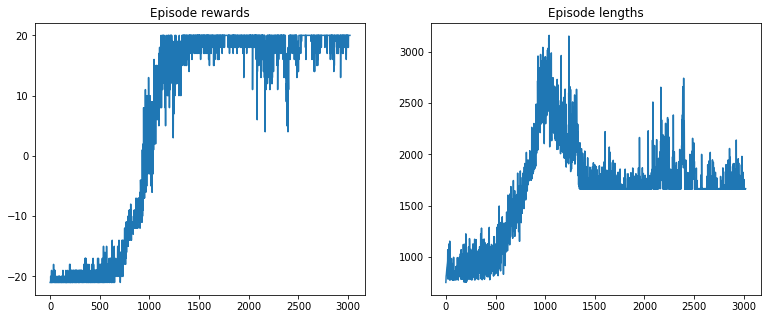

In [10]:
# plot results
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode rewards")
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode lengths")